In [1]:
import io
import os
import time
import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")
os.environ['TF_CPP_MIN_LOG_LEVEL']='0'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_FLAGS']='--xla_gpu_strict_conv_algorithm_picker=false'
import jax
import jax.numpy as jnp
import numpy as np
import datasets
import likelihood
import sde_lib
import losses
from models import utils as mutils
import logging
import flax
from typing import Any
from flax.training import checkpoints
# Keep the import below for registering all model definitions
from models import ncsnpp
import matplotlib.pyplot as plt
from bpd_eval import convert_checkpoint, randomize_tiles_shuffle_blocks_batch

In [2]:
from configs.subvp.svhn_ddpmpp_continuous import get_config
config = get_config()
config.eval.batch_size = 16
workdir = 'outs/cifar10_subvp_likelihood_tw'
eval_folder="test_eval_interpolate_extra_svhn_cifar"
eval_dir = os.path.join(workdir, eval_folder)
checkpoint_dir = os.path.join(workdir, "checkpoints")
tf.io.gfile.makedirs(eval_dir)
rng = jax.random.PRNGKey(config.seed + 1)

In [3]:
config.data.dataset = 'CIFAR10'
_, cifar_eval, _ = datasets.get_non_batch_dataset(config,
                                        additional_dim=None,
                                        uniform_dequantization=True, evaluation=True)
config.data.dataset = 'SVHN'
_, svhn_eval, _ = datasets.get_non_batch_dataset(config,
                                        additional_dim=None,
                                        uniform_dequantization=True, evaluation=True)
cifar_eval = cifar_eval.batch(config.eval.batch_size, drop_remainder=True)
svhn_eval = svhn_eval.batch(config.eval.batch_size, drop_remainder=True)

In [4]:
# Create data normalizer and its inverse
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)

In [4]:
# Initialize model
rng, model_rng = jax.random.split(rng)
score_model, init_model_state, initial_params = mutils.init_model(model_rng, config)
optimizer = losses.get_optimizer(config).create(initial_params)
state = mutils.State(step=0, optimizer=optimizer, lr=config.optim.lr,
                    model_state=init_model_state,
                    ema_rate=config.model.ema_rate,
                    params_ema=initial_params,
                    rng=rng)  # pytype: disable=wrong-keyword-args
state = checkpoints.restore_checkpoint(checkpoint_dir, state, step=config.eval.end_ckpt)
state = convert_checkpoint(state)
# Setup SDEs
sde = sde_lib.get_sde(config.training.sde, config.model)
sampling_eps = config.sampling.smallest_time
# Build the likelihood computation function
likelihood_fn = likelihood.get_likelihood_fn(sde, score_model, inverse_scaler, eps=sampling_eps)

2022-08-12 16:53:16.959915: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-12 16:53:16.959947: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-12 16:53:19.477901: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2

In [6]:
# Replicate the training state for executing on multiple devices
pstate = flax.jax_utils.replicate(state)

In [64]:
l1=4
l2=4
H=8
W=8

In [139]:
block_width = 8
n = 32 // 8
a = svhn_image.numpy()
M = N = 8

In [141]:
a.shape

(32, 32, 3)

In [177]:
m,n,p = a.shape
b = a.reshape(m//M,M,n//N,N, p).swapaxes(1,2).reshape(-1,M*N, p)
b = jax.random.permutation(rng, b)
out = b.reshape(m//M,n//N,M,N,p).swapaxes(1,2).reshape(a.shape)

In [178]:
np.arange(16).reshape(4, 4)
jax.random.permutation(rng, np.arange(16).reshape(4, 4), axis=0)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [179]:
b.shape

(16, 64, 3)

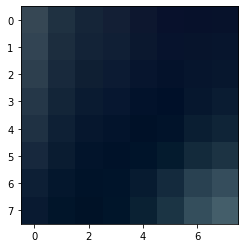

In [180]:
plt.imshow(b[5].reshape(8, 8, 3))

In [185]:
# rng = jax.random.PRNGKey(0)
# rng, *skeys = jax.random.split(rng, 41)
# images = randomize_tiles_shuffle_blocks_batch(inter_images[0].numpy(), 8, 8, jnp.array(skeys))
# plt.imshow(images[20])

In [7]:
cifar_iter = iter(cifar_eval)
svhn_iter = iter(svhn_eval) 
for i in range(min(len(cifar_eval), len(svhn_eval))):
    cifar_batch = next(cifar_iter)
    svhn_batch = next(svhn_iter)
    cifar_idx = np.random.randint(0, config.eval.batch_size)
    svhn_idx = np.random.randint(0, config.eval.batch_size)
    cifar_image = cifar_batch['image'][cifar_idx]
    svhn_image = svhn_batch['image'][svhn_idx]
    inter_images = [svhn_image + theta*(cifar_image - svhn_image) for theta in np.arange(-0.5, 1.5, 0.05)]
    inter_images = tf.stack(inter_images, 0)
    inter_images = inter_images[np.newaxis, ...]

    data = jax.tree_util.tree_map(lambda x: scaler(x._numpy()), inter_images)
    rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
    step_rng = jnp.asarray(step_rng)
    bpd = likelihood_fn(step_rng, pstate, data)[0]
    bpd = bpd.reshape(-1)

    # Save bits/dim to disk or Google Cloud Storage
    bpd_npz_path = os.path.join(eval_dir,
                                    f"{config.eval.bpd_dataset}_inter_bpd_{i}_{bpd[10]:.4f}_{bpd[-10]:.4f}.npz")
    with tf.io.gfile.GFile(bpd_npz_path, "wb") as fout:
        io_buffer = io.BytesIO()
        np.savez_compressed(io_buffer, bpd)
        fout.write(io_buffer.getvalue())


/home/cyanos/Workspace/OOD_Generative_models/score_flow-main/venv/lib/python3.10/site-packages/flax/jax_utils.py:61: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  return jax.tree_map(lambda x: x[0], tree)
2022-08-12 16:53:37.048316: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.80GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-12 16:53:37.359919: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


KeyboardInterrupt: 

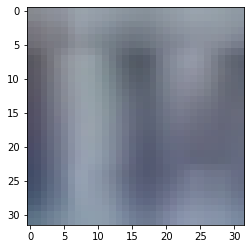

In [9]:
plt.imshow(inter_images[0,10])

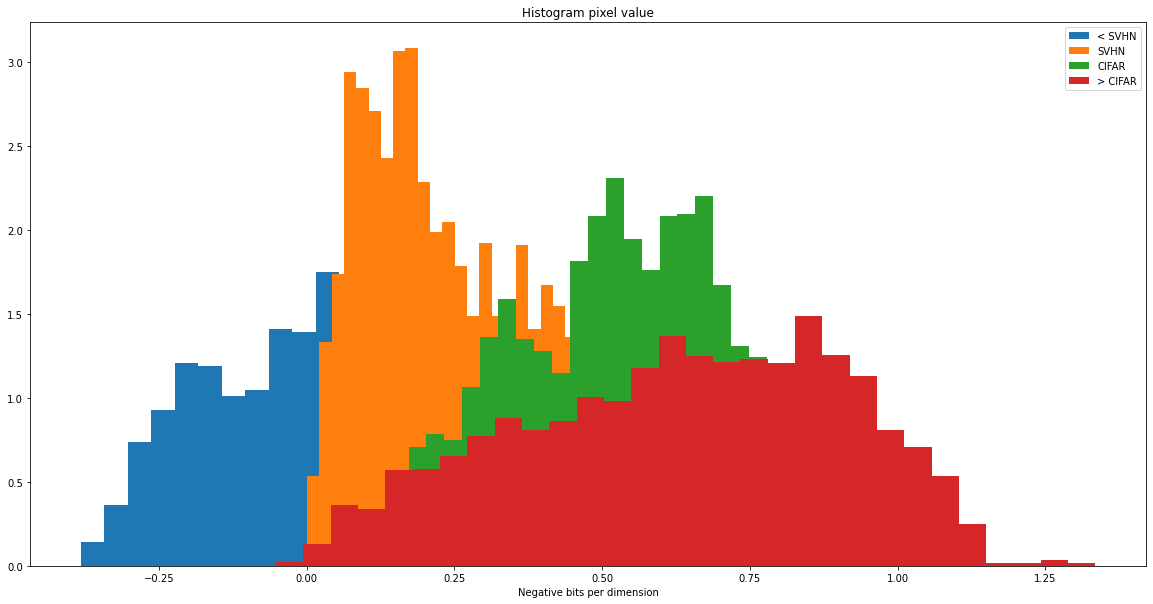

In [35]:
cifar_batch = next(cifar_iter)
svhn_batch = next(svhn_iter)
cifar_idx = np.random.randint(0, config.eval.batch_size)
svhn_idx = np.random.randint(0, config.eval.batch_size)
cifar_image = cifar_batch['image'][cifar_idx]
svhn_image = svhn_batch['image'][svhn_idx]
inter_images = [svhn_image + theta*(cifar_image - svhn_image) for theta in np.arange(-0.5, 1.5, 0.05)]
inter_images = tf.stack(inter_images, 0)
inter_images = inter_images[np.newaxis, ...]

plt.figure(figsize=(20,10))
plt.title("Histogram pixel value")
plt.xlabel("Negative bits per dimension")
plt.hist(inter_images[0,0].numpy().flatten(), label="< SVHN", density=True, bins=30)
plt.hist(inter_images[0,10].numpy().flatten(), label="SVHN", density=True, bins=30)
plt.hist(inter_images[0,30].numpy().flatten(), label="CIFAR", density=True, bins=30)
plt.hist(inter_images[0,39].numpy().flatten(), label="> CIFAR", density=True, bins=30)
plt.legend()
plt.show()

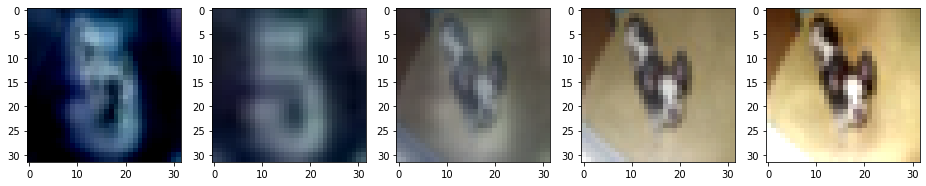

In [39]:
fig, axes = plt.subplots(1, 5, figsize=(16, 14))
for i, ax in enumerate(axes.flat):
    if i < 4:
        ax.imshow(inter_images[0,i*10])
    else:
        ax.imshow(inter_images[0,i*10 - 1])


In [ ]:
# cifar_iter = iter(cifar_eval)
# for i in range(len(cifar_eval)):
#     cifar_batch = next(cifar_iter)
#     cifar_idx1 = np.random.randint(0, config.eval.batch_size)
#     cifar_idx2 = np.random.randint(0, config.eval.batch_size)
#     cifar_image1 = cifar_batch['image'][cifar_idx1]
#     cifar_image2 = cifar_batch['image'][cifar_idx2]
#     inter_images = [cifar_image2 + theta*(cifar_image1 - cifar_image2) for theta in np.arange(0, 1., 0.05)]
#     inter_images = tf.stack(inter_images, 0)
#     inter_images = inter_images[np.newaxis, ...]

#     data = jax.tree_util.tree_map(lambda x: scaler(x._numpy()), inter_images)
#     rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
#     step_rng = jnp.asarray(step_rng)
#     bpd = likelihood_fn(step_rng, pstate, data)[0]
#     bpd = bpd.reshape(-1)

#     # Save bits/dim to disk or Google Cloud Storage
#     bpd_npz_path = os.path.join(eval_dir,
#                                     f"{config.eval.bpd_dataset}_inter_bpd_{i}_{bpd[0]:.4f}_{bpd[-1]:.4f}.npz")
#     with tf.io.gfile.GFile(bpd_npz_path, "wb") as fout:
#         io_buffer = io.BytesIO()
#         np.savez_compressed(io_buffer, bpd)
#         fout.write(io_buffer.getvalue())

/home/cyanos/Workspace/OOD_Generative_models/score_flow-main/venv/lib/python3.10/site-packages/flax/jax_utils.py:61: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  return jax.tree_map(lambda x: x[0], tree)
2022-08-12 16:17:23.015876: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


KeyboardInterrupt: 